In [1]:
import os
from shutil import copy
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm

In [2]:
# Rearrange the data provided and resize images into (224, 224)
test_image = "02"

re_arranged_signatures_train = "./signatures_dataset_sklearn_split/train"
re_arranged_signatures_test = "./signatures_dataset_sklearn_split/test"

signatures_genuine_dir = "./archive/sample_signature/sample_Signature/genuine"
signatures_forged_dir = "./archive/sample_signature/sample_Signature/forged"

os.mkdir(re_arranged_signatures_train)
os.mkdir(re_arranged_signatures_test)

for signature in os.listdir(signatures_genuine_dir):
    if os.path.isfile(os.path.join(signatures_genuine_dir, signature)):
        try:
            dir_name = signature[9] + signature[10] + signature[11] + "_genuine"
            os.mkdir(os.path.join(re_arranged_signatures_train, dir_name))
            os.mkdir(os.path.join(re_arranged_signatures_test, dir_name))
        except FileExistsError:
            # Directory already exists
            pass
        
        image = signature[7] + signature[8]
        
        if image != test_image:
            copy(os.path.join(signatures_genuine_dir, signature), os.path.join(re_arranged_signatures_train, dir_name))
        else:
            copy(os.path.join(signatures_genuine_dir, signature), os.path.join(re_arranged_signatures_test, dir_name))

for signature in os.listdir(signatures_forged_dir):
    if os.path.isfile(os.path.join(signatures_forged_dir, signature)):
        try:
            dir_name = signature[9] + signature[10] + signature[11] + "_forged"
            os.mkdir(os.path.join(re_arranged_signatures_train, dir_name))
            os.mkdir(os.path.join(re_arranged_signatures_test, dir_name))
        except FileExistsError:
            # Directory already exists
            pass
        
        image = signature[7] + signature[8]
        
        if image != test_image:
            copy(os.path.join(signatures_forged_dir, signature), os.path.join(re_arranged_signatures_train, dir_name))
        else:
            copy(os.path.join(signatures_forged_dir, signature), os.path.join(re_arranged_signatures_test, dir_name))
            

Image shape: (735, 1460)


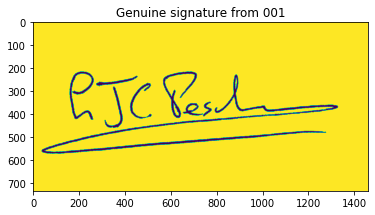

In [3]:
img1 = plt.imread("./signatures_dataset_sklearn_split/train/001_genuine/NFI-00101001.png")
plt.title("Genuine signature from 001")
plt.imshow(img1)
print("Image shape:", img1.shape)

Image shape: (453, 1247)


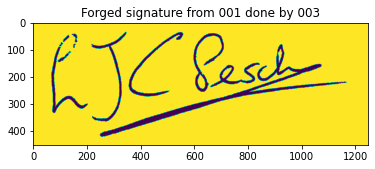

In [4]:
img2 = plt.imread("./signatures_dataset_sklearn_split/train/001_forged/NFI-00301001.png")
plt.title("Forged signature from 001 done by 003")
plt.imshow(img2)
print("Image shape:", img2.shape)

In [5]:
# Pre-processing
SIZE = 224

X = []
y = []
signature_labels = []

# Train data
for person in os.listdir('./signatures_dataset_sklearn_split/train'):
    for signature in glob.glob('./signatures_dataset_sklearn_split/train/' + person + '/*.*'):
        
        signature_labels.append(signature)
        img = cv2.imread(signature)
        # Transform BGR image into GRAY image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize all images to (SIZE, SIZE) images to have the same features
        img = cv2.resize(img, (SIZE, SIZE))
        X.append(img)
        
        if person[-1] == 'd':
            y.append(np.array(1))
        else:
            y.append(np.array(0))

# Test data
for person in os.listdir('./signatures_dataset_sklearn_split/test'):
    for signature in glob.glob('./signatures_dataset_sklearn_split/test/' + person + '/*.*'):
        
        signature_labels.append(signature)
        img = cv2.imread(signature)
        # Transform BGR image into GRAY image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize all images to (SIZE, SIZE) images to have the same features
        img = cv2.resize(img, (SIZE, SIZE))
        X.append(img)
        
        if person[-1] == 'd':
            y.append(np.array(1))
        else:
            y.append(np.array(0))
            
X = np.array(X)
y = np.array(y)

print("Data set mean: \n{}\n".format(np.mean(X)))
print("X_train shape: \n{}\n".format(X.shape))
print("y_train shape: \n{}\n".format(y.shape))


Data set mean: 
243.16029363307823

X_train shape: 
(300, 224, 224, 3)

y_train shape: 
(300,)



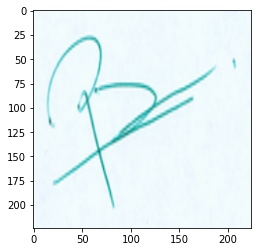

In [6]:
# Exemple of signature pos-processed
plt.imshow(X[np.random.randint(0,X.shape[0]+1),:])

In [7]:
# Normalize data and data splitting
X_lr = X.copy()
y_lr = y.copy()

# Reshape (300, 224, 224, 3) into (300, 150528)
X_lr = X_lr.reshape(X_lr.shape[0], X_lr.shape[1] * X_lr.shape[2] * X_lr.shape[3])

# Normalize values (before: 0-255) 
X_lr = StandardScaler().fit_transform(X_lr)

# Split whole dataset
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state=0)

print("Number signatures train dataset: ", X_train_lr.shape[0])
print("Number signatures test dataset: ", X_test_lr.shape[0])
print("Total number of signatures: ", (X_train_lr.shape[0] + X_test_lr.shape[0]))

Number signatures train dataset:  210
Number signatures test dataset:  90
Total number of signatures:  300


In [8]:
print("Data set mean: \n{}\n".format(np.mean(X_lr)))
print("X_train_lr shape: \n{}\n".format(X_train_lr.shape))
print("X_test_lr shape: \n{}\n".format(X_test_lr.shape))
print("y_train_lr shape: \n{}\n".format(y_train_lr.shape))
print("y_test_lr shape: \n{}\n".format(y_test_lr.shape))

Data set mean: 
-3.209324970050226e-17

X_train_lr shape: 
(210, 150528)

X_test_lr shape: 
(90, 150528)

y_train_lr shape: 
(210,)

y_test_lr shape: 
(90,)



In [9]:
# Find the best hyper-parameter C. Optimizing for recall perf. metric 
def print_gridsearch_scores(x_train_data,y_train_data):
    c_param_range = [0.01,0.1,1,10]

    clf = GridSearchCV(LogisticRegression(), {"C": c_param_range}, cv=5, scoring='recall')
    clf.fit(x_train_data,y_train_data)

    print("Best parameters found on CV(dev) set:")
    print()
    print(clf.best_params_)

    print("K-fold Score (Recall) on CV (dev) set:")
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #Visualization of the K-fold Recall results for different hyper parameters C
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    return clf.best_params_["C"]

In [10]:
# Get the best C for provided dataset
best_c = print_gridsearch_scores(X_train_lr, y_train_lr)

Best parameters found on CV(dev) set:

{'C': 0.01}
K-fold Score (Recall) on CV (dev) set:
0.605 (+/-0.240) for {'C': 0.01}
0.605 (+/-0.240) for {'C': 0.1}
0.605 (+/-0.240) for {'C': 1}
0.605 (+/-0.189) for {'C': 10}


In [11]:
# Use the best C to train LogReg model
lr = LogisticRegression(C=best_c)
lr.fit(X_train_lr, y_train_lr)
y_pred = lr.predict(X_test_lr)

print('Accuracy: ', lr.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Accuracy:  0.7111111111111111
Precision: 0.7109683794466404
Recall: 0.7109683794466404
Fscore: 0.7109683794466404


In [12]:
# Linear SVM
classifier = svm.SVC(kernel="linear")
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Accuracy:  0.6777777777777778
Precision: 0.6781981085116974
Recall: 0.6768774703557312
Fscore: 0.6767801857585138


In [13]:
# RBF SVM
classifier = svm.SVC(kernel="rbf")
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Accuracy:  0.5444444444444444
Precision: 0.5615384615384615
Recall: 0.5494071146245059
Fscore: 0.5231942111383899


In [14]:
# sigmoid SVM
classifier = svm.SVC(kernel="sigmoid")
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Accuracy:  0.6
Precision: 0.683277027027027
Recall: 0.6072134387351779
Fscore: 0.5571350464734828


In [16]:
# poly SVM
classifier = svm.SVC(kernel="poly")
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Accuracy:  0.4888888888888889
Precision: 0.24444444444444444
Recall: 0.5
Fscore: 0.3283582089552239


/home/dvc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Neural network models (supervised)
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(15,),batch_size=64,verbose=True)
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))

Accuracy:  0.6777777777777778
Precision: 0.6815400305966344
Recall: 0.6758893280632412
Fscore: 0.6745230078563412
